#DOWNLOAD GLOVE EMBEDDING

**Runtime: 3 min**

In [1]:
#Required for preprocessing the text
!pip install contractions


     |████████████████████████████████| 287 kB 5.1 MB/s 
     |████████████████████████████████| 106 kB 46.3 MB/s 


In [2]:
#Glove Embedding Pretrained Weights
#It takes approximately 2 min to install
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2022-04-27 14:26:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-27 14:26:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-27 14:26:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

#IMPORTS

In [3]:
#NLTK imports for preprocessing the text
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import string
import contractions

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from xgboost import XGBClassifier

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

#EXPLORATORY DATA ANALYSIS

In [5]:
#Reading Fake and Real News Data
fake_path = '/content/Fake.csv'
real_path = '/content/True.csv'

fake = pd.read_csv(fake_path)
real = pd.read_csv(real_path)

#Assign classes 0 For Fake News, 1 For Real News
fake['class'], real['class'] = 0, 1

In [6]:
#Concatenating dataframes and Resampling the data by 0.3
df = pd.concat([fake, real], axis=0)
df = df.sample(frac=0.3, random_state=101).reset_index(drop=True)
print('Shape of DataFrame')
print('------------------')
print(f'{df.shape}')
df.head(5)

Shape of DataFrame
------------------
(13469, 5)


,title,text,subject,date,class
0,"MICHELLE, SASHA AND MALIA Will Join Barack On ...",The Obama s just added millions onto the taxpa...,left-news,"Mar 17, 2016",0
1,80-Year-Old Man Guns Down 81-Year-Old Over Ch...,"On June 13, 80-year-old Edward Acquisto shot a...",News,"June 29, 2016",0
2,Judge tells Trump University litigants they wo...,SAN DIEGO (Reuters) - The U.S. judge overseein...,politicsNews,"November 10, 2016",1
3,Danish government wins backing for 2018 budget...,COPENHAGEN (Reuters) - Denmark s right-wing go...,worldnews,"December 19, 2017",1
4,China And Russia Chase US Destroyer Away Afte...,Trump s loyalty to Vladimir Putin is being tes...,News,"April 17, 2017",0


**Fake News Count Time Series Analysis**

In [7]:
#Subselect fake news data to analize fake news count by date
df_date = fake[['title','date']]


#Parse date column into months
df_date['month'] = df_date['date'].apply(lambda x : x.split(" ")[0])

#Replace Month with Numerical Representation
to_replace = {"January" : "01", "Jan" : "01",
              "February" : "02", "Feb" : "02",
              "March" : "03", "Mar" : "03",
              "April" : "04", "Apr" : "04",
              "May" : "05",
              "June" : "06", "Jun" : "06",
              "July" : "07", "Jul" : "07",
              "August" : "08", "Aug" : "08",
              "September" : "09", "Sep" : "09",
              "October" : "10", "Oct" : "10",
              "November" : "11", "Nov" : "11",
              "December" : "12", "Dec" : "12"}

df_date.month.replace(to_replace, inplace=True)

#Drop rows that is not including months
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
df_date = df_date[df_date.month.isin(months)]

#Parse date column into years
df_date['year'] = df_date['date'].apply(lambda x : x.split(" ")[2])

#Create date column with month and year only
df_date['date'] = df_date['month'] + "/" + df_date['year']

#Change type of date column to datetime
df_date['date'] = pd.to_datetime(df_date['date'], format="%m/%Y")

#Sort date column ascending to plot
df_date.sort_values('date', inplace=True)

#Groupby date column to calculate count of fake news
df_date = df_date.groupby(['date']).agg(count=('date','count')).reset_index()

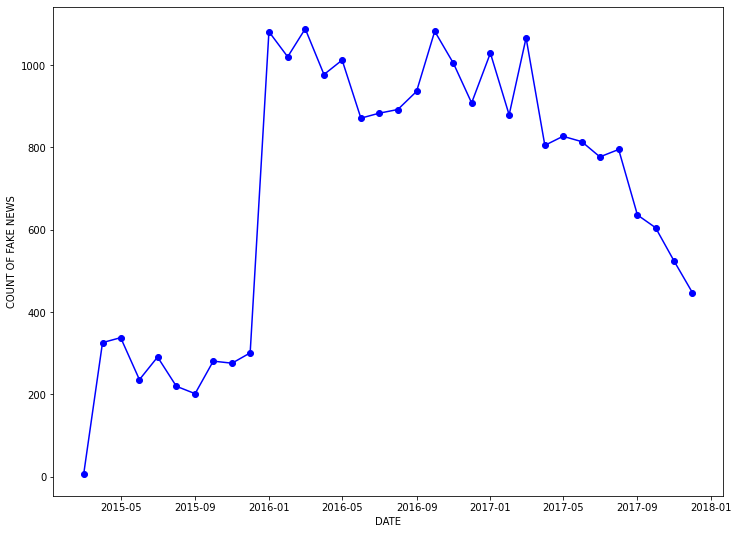

In [8]:
#Plot Count of Fake News Monthly
plt.figure(figsize=(12,9))
plt.plot(df_date['date'],df_date['count'], 'bo-')
plt.xlabel('DATE')
plt.ylabel('COUNT OF FAKE NEWS')
plt.show()

#We can see in the below plot there is a big spike in the count of fake news in January 2016
#If we look in the internet what's happening around that time there was a presidential election (Trump/Clinton) in 2016 which concluded in November 2016
#Probably there was a severe manipulation by the media for both parties to win the election
#https://en.wikipedia.org/wiki/2016_United_States_presidential_election

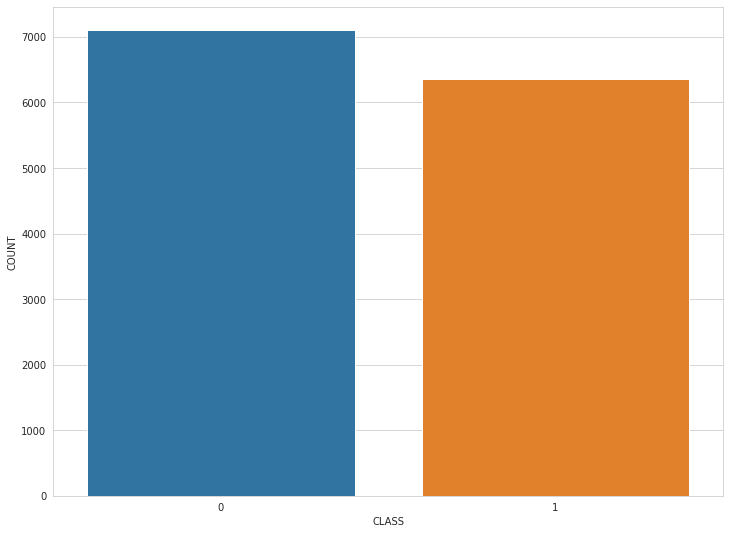

In [9]:
#Plotting counts of fake and real news
plt.figure(figsize=(12,9))
sns.set_style('whitegrid')
plot = sns.countplot(data=df , x='class')
plot.set(xlabel='CLASS', ylabel='COUNT')
plt.show()

In [10]:
#Check the dtypes and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13469 entries, 0 to 13468
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    13469 non-null  object
 1   text     13469 non-null  object
 2   subject  13469 non-null  object
 3   date     13469 non-null  object
 4   class    13469 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 526.3+ KB


In [11]:
#Print count of null values if there is any
df.isnull().sum()

title      0
text       0
subject    0
date       0
class      0
dtype: int64

In [12]:
#Rename the subject categories
#Here politicsNews and politics should be in one category

to_replace = {'politicsNews': 'political news',
              'politics' : 'political news',
              'worldnews' : 'world news',
              'News' : 'general news',
              'left-news' : 'left news',
              'Government News' : 'government news',
              'US_News' : 'US news',
              'Middle-east' : 'Middle-East news'}

df.subject.replace(to_replace, inplace=True) 

In [13]:
#Count of each news category
df.subject.value_counts()

political news      5453
world news          2977
general news        2754
left news           1357
government news      470
US news              235
Middle-East news     223
Name: subject, dtype: int64

**Countplot News Category by Fake/Real News**

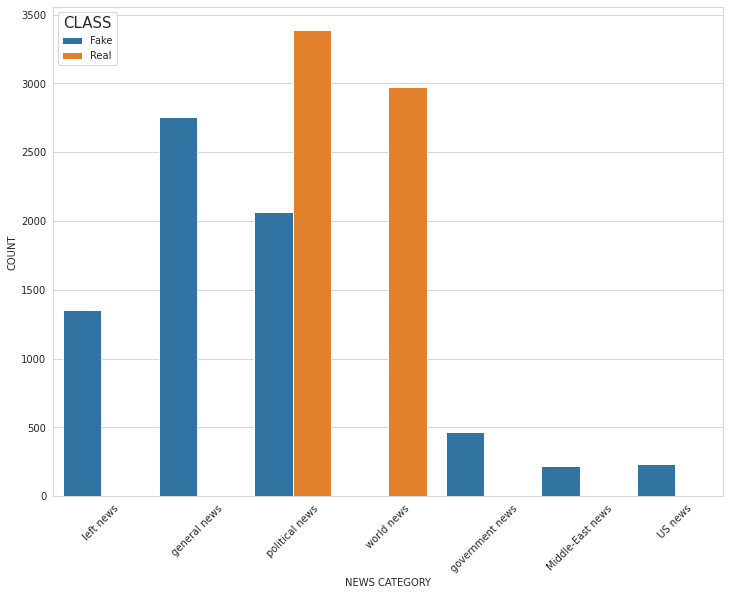

In [14]:
#Plot each category by class to see the relevance
plt.figure(figsize=(12,9))
plot = sns.countplot(data=df, x='subject', hue='class')
plot.set(xlabel='NEWS CATEGORY', ylabel='COUNT')
plt.legend(title='CLASS', fontsize=10, title_fontsize=15, loc='upper left', labels=['Fake', 'Real'])
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plt.show()

#As we can see in the below box plot, most of the fake news are political news.
#This could be a result of "smear campaign" by the politicians against to each other. 

#PREPROCESSING TEXT 
**Runtime: 1 min**

In [15]:
#Combine text with the title column and drop the other columns

df['text'] = df['title'] + ' ' + df['text']
cols_todrop = ['title', 'subject', 'date']
df.drop(columns=cols_todrop, axis=1, inplace=True)

In [16]:
#Dropping Duplicated Rows

number_of_duplicates = df.duplicated().sum()
print(f'Expected number of rows after dropping duplicates {len(df)-df.duplicated().sum()}\n')
df.drop_duplicates(subset=['text'], keep='first', inplace=True)
print(f'Number of rows after dropping duplicates : {df.shape[0]}')

Expected number of rows after dropping duplicates 12924

Number of rows after dropping duplicates : 12924


In [17]:
#Defining punctuations and adding extra punctuations that's not included in the string lib

punctuations = string.punctuation
punctuations = punctuations + '…“”’‘–’'

In [18]:
#Define Preprocessing Functions

def remove_url(text):
  """
  removes urls from text
  """
  removed = re.sub(r"http\S+", "", text)
  return removed


def remove_punctuations(text):
  """
  removes punctuations from text
  """
  removed = "".join([i for i in text if i not in punctuations])
  return removed

def replace_contractions(text):
  """
  replaces contractions
  example : 
  you're ----> you are
  it's   ----> it is
  ima    ----> i am going to
  """
  replaced = contractions.fix(text)
  return replaced

def tokenize_words(text):
  """
  turns text string to list of words
  """
  tokenized = word_tokenize(text)
  return tokenized

def remove_stopwords(text):
  """
  removes stopwords and lowers all words
  stopwords : me, myself, I, we, which, who, whom, etc.
  """
  stopwords = nltk.corpus.stopwords.words('english')
  removed = [i.lower() for i in text if i not in stopwords]
  return removed

def lemmatize_words(text):
  """
  lemmatize words
  example :
  computers ----> computer
  changing  ----> change

  """
  lemmatizer = WordNetLemmatizer()
  lemmatized = [lemmatizer.lemmatize(i) for i in text]
  return lemmatized

def preprocess_text(text):
  """
  helper function to preprocess text
  applies all the functions defined above
  """
  text = remove_url(text)
  text = remove_punctuations(text)
  text = replace_contractions(text)
  text = tokenize_words(text)
  text = remove_stopwords(text)
  text = lemmatize_words(text)

  return text
  #add callback

In [19]:
#Apply preprocessing to the test
#df['processed_text'] = df['text'].apply(preprocess_text) # 59seconds
%%time
df.insert(0, 'processed_text', df['text'].apply(preprocess_text) ) #54seconds

CPU times: user 1min, sys: 1.08 s, total: 1min 1s
Wall time: 1min 7s


In [20]:
df.head()

,processed_text,text,class
0,"[michelle, sasha, and, malia, will, join, bara...","MICHELLE, SASHA AND MALIA Will Join Barack On ...",0
1,"[80yearold, man, gun, down, 81yearold, over, c...",80-Year-Old Man Guns Down 81-Year-Old Over Ch...,0
2,"[judge, tell, trump, university, litigant, wou...",Judge tells Trump University litigants they wo...,1
3,"[danish, government, win, backing, 2018, budge...",Danish government wins backing for 2018 budget...,1
4,"[china, and, russia, chase, u, destroyer, away...",China And Russia Chase US Destroyer Away Afte...,0


In [21]:
#Delete text column
del df['text']

In [22]:
#Create length column to show count of words
df['length'] = df['processed_text'].apply(lambda x: len(x))

In [23]:
#Lets check the top5 longest news
df.sort_values('length', ascending=False).head(5)

,processed_text,class,length
6186,"[antiamerican, george, soros, lock, arm, with,...",0,4773
7414,"[year, in, review, 2017, top, ten, conspiracy,...",0,3634
8913,"[an, american, tragedy, who, really, killed, j...",0,3292
6812,"[orlando, known, wolf, watched, fbi, worked, d...",0,3164
5662,"[obama, commute, 61, prisoner, sentencesheres,...",0,2650


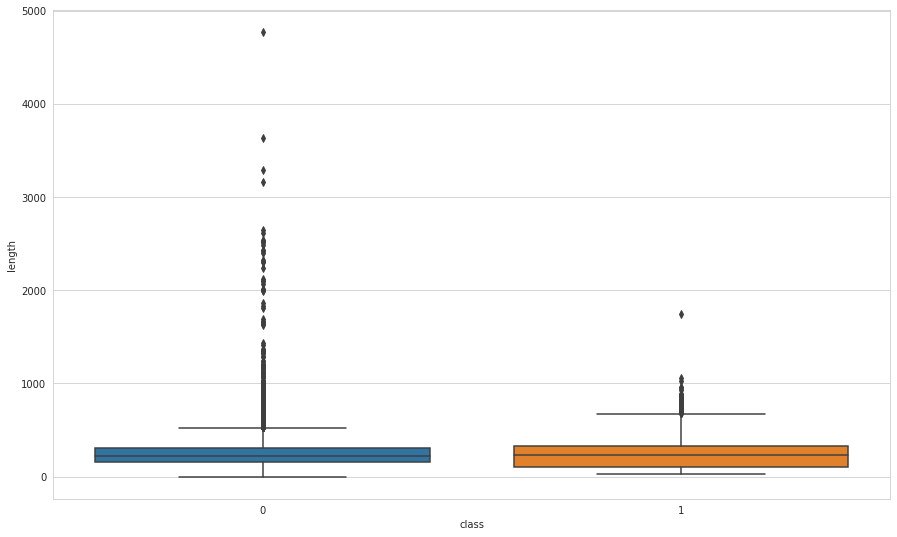

In [24]:
#Boxplot for count of words
plt.figure(figsize=(15,9))
sns.boxplot(x="class", y="length", data=df)
plt.show()

In [25]:
#If we pick length smaller than 1000 we will be still able to have more than 99% of the data
#So we don't need to have a huge matrix when we tokenize the text we will pick the maxlen=1000
countsmaller1000 = df[df.length <= 1000]['length'].count()
countall = df.length.count()
print(f"If we select only df.length.count() < 1000; We still have {countsmaller1000/countall*100:.4f} % of the data")

If we select only df.length.count() < 1000; We still have 99.3965 % of the data


In [26]:
mean_realnews = np.mean(df[df['class']==1]['length'])
mean_fakenews = np.mean(df[df['class']==0]['length'])

print(f"Average count of words for Real News : {mean_realnews:.4f}")
print()
print(f"Average count of words for Fake News : {mean_fakenews:.4f}")
print()
print("This shows in average Fake news tend to have more words than Real news")

Average count of words for Real News : 246.9083

Average count of words for Fake News : 260.2050

This shows in average Fake news tend to have more words than Real news


#MODEL 1: LSTM WITH PRETRAINED GLOVE EMBEDDING
**Runtime: 3 min**



In [27]:
#Split Train and Test test
#0.3 Test and 0.7 Train

x_train, x_test, y_train, y_test = train_test_split(df['processed_text'], df['class'], test_size=0.3, random_state=101)

print(f"Number of x_train : {len(x_train)}\n\nNumber of x_test : {len(x_test)}")

Number of x_train : 9046

Number of x_test : 3878


In [28]:
#Instantiate Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

#pad sequences with maxlen=1000
#previously we saw that 99% of the data has less than 1000 words

maxlen = 1000
#create sequences in x_train and pad them with maxlen=1000
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(tokenized_train, maxlen=maxlen)

#create sequences in x_test and pad them with maxlen=1000
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(tokenized_test, maxlen=maxlen)

print(f"Train Set Shape : {x_train.shape}")
print("----------------------------------")
print(f"Test Set Shape : {x_test.shape}")

Train Set Shape : (9046, 1000)
----------------------------------
Test Set Shape : (3878, 1000)


In [29]:
#Creating embedding function for assigning glove embedding vectors to tokens
#Source deep learning with python by francois challot 2nd edition

def embedding_function(filepath, word_index, embedding_dim):
  vocab_size = len(word_index) + 1
  embedding_matrix = np.zeros((vocab_size, embedding_dim))

  with open(filepath, encoding='utf8') as f:
    for line in f:
      word, *vector = line.split()
      if word in word_index:
        idx = word_index[word]
        embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
  
  return embedding_matrix


In [30]:
#Assign glove embeddings
embedding_dim = 50
filepath = '/content/glove.6B.50d.txt'

glove_embedding = embedding_function(filepath, tokenizer.word_index, embedding_dim)

In [31]:
#Example for word index 1, there is 50 dim
print('Example Embedding Vectors\n')
print('--------------------------------\n')
glove_embedding[1]

Example Embedding Vectors

--------------------------------



array([ 0.45769   ,  0.85191   ,  0.31097999,  1.34780002, -0.021703  ,
       -0.05467   , -0.17405   , -0.71013999, -0.57441002,  0.49786001,
       -0.89381999,  0.58661002, -0.77012998,  0.23779   ,  0.37652001,
        1.36679995,  0.34667   ,  0.082452  ,  0.17561001,  0.056062  ,
        0.50818002,  0.33750999, -0.85170001,  0.034619  , -0.57236999,
       -1.15339994, -0.54158998,  0.24327999,  0.018737  , -0.58644998,
        0.15261   ,  0.53372002, -0.27601001,  0.065097  ,  0.39680001,
       -0.62892002,  0.0046726 ,  0.081347  , -0.32578999, -0.60933   ,
       -0.36464   ,  0.17591   ,  0.0050718 ,  1.36059999, -0.78583002,
        0.083121  , -0.75184   , -0.74225998,  0.77052999,  0.26394001])

In [32]:
#Clear keras backend adn set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(101)
np.random.seed(101)

#input and output dimension of ebedding layer
input_dim = len(tokenizer.word_index)+1
output_dim=50

#building the LSTM model
#embedding layers has glove embedding pretrained weights, input_length is 1000
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim, weights=[glove_embedding], input_length=maxlen, trainable=False),
  tf.keras.layers.LSTM(units=128, dropout=0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

#adam optimizer and binarycrossentropy loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()

#early stopping callbacks to stop training if there is no change with the last N epochs
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)

#compile model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [33]:
#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          4530450   
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,632,467
Trainable params: 102,017
Non-trainable params: 4,530,450
_________________________________________________________________


In [34]:
%%time
#Model fitting on x_train and y_train
batch_size=256
epochs = 10

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/10
36/36 [==============================] - 18s 315ms/step - loss: 0.4114 - accuracy: 0.8351 - val_loss: 0.2804 - val_accuracy: 0.8816
Epoch 2/10
36/36 [==============================] - 11s 297ms/step - loss: 0.2335 - accuracy: 0.9081 - val_loss: 0.2113 - val_accuracy: 0.9190
Epoch 3/10
36/36 [==============================] - 11s 300ms/step - loss: 0.2362 - accuracy: 0.9082 - val_loss: 0.2618 - val_accuracy: 0.9030
Epoch 4/10
36/36 [==============================] - 11s 296ms/step - loss: 0.2184 - accuracy: 0.9153 - val_loss: 0.2044 - val_accuracy: 0.9247
Epoch 5/10
36/36 [==============================] - 11s 302ms/step - loss: 0.1837 - accuracy: 0.9307 - val_loss: 0.1654 - val_accuracy: 0.9373
Epoch 6/10
36/36 [==============================] - 11s 315ms/step - loss: 0.1752 - accuracy: 0.9351 - val_loss: 0.1699 - val_accuracy: 0.9381
Epoch 7/10
36/36 [==============================] - 11s 301ms/step - loss: 0.1777 - accuracy: 0.9318 - val_loss: 0.1848 - val_accuracy: 0.9270

In [35]:
#Save Model
model.save('model_lstm.h5')

In [36]:
#Print Accuracy and F1 Score

#predict on x_test
y_pred = model.predict(x_test)
y_pred = np.where(y_pred<0.5, 0, 1)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"LSTM Model with GLOVE Embedding F1 SCORE : {f1:.4f}")
print("------------------------------------------------------")
print(f"LSTM Model with GLOVE Embedding ACCURACY SCORE : {accuracy:.4f}")

LSTM Model with GLOVE Embedding F1 SCORE : 0.9316
------------------------------------------------------
LSTM Model with GLOVE Embedding ACCURACY SCORE : 0.9350


#MODEL 2: CNN WITH WORD EMBEDDING FROM SCRATCH
**Runtime : 1 min**

In [37]:
#Split Train and Test test
#0.3 Test and 0.7 Train

x_train, x_test, y_train, y_test = train_test_split(df['processed_text'], df['class'], test_size=0.3, random_state=111)

print(f"Number of x_train : {len(x_train)}\n\nNumber of x_test : {len(x_test)}")

Number of x_train : 9046

Number of x_test : 3878


In [38]:
#Instantiate Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

#pad sequences post with maxlen=1000
#previously we saw that 99% of the data has less than 1000 words

maxlen = 1000

#create sequences in x_train and pad them with maxlen=1000
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(tokenized_train, maxlen=maxlen)

#create sequences in x_test and pad them with maxlen=1000
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(tokenized_test, maxlen=maxlen)

print(f"Train Set Shape : {x_train.shape}")
print("----------------------------------")
print(f"Test Set Shape : {x_test.shape}")

Train Set Shape : (9046, 1000)
----------------------------------
Test Set Shape : (3878, 1000)


In [39]:
#Clear keras backend adn set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(101)
np.random.seed(101)

#Embedding layer with 30 dimension
output_dim = 30 
input_dim = len(tokenizer.word_index)

#Building model with Embedding layers from scratch with 30 dimension
#Convolution layer with 128 filters
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=maxlen),
  tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu'),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

#Adam optimizer with lr=0.001
#Loss function binarycrossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()

#early stopping callbacks to stop training if there is no change with the last N epochs
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [40]:
#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 30)          2741160   
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          19328     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                        

In [41]:
%%time
#Model fitting on x_train and y_train
batch_size = 256
epochs = 10

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/10
36/36 [==============================] - 10s 84ms/step - loss: 0.6908 - accuracy: 0.5318 - val_loss: 0.6769 - val_accuracy: 0.7081
Epoch 2/10
36/36 [==============================] - 2s 67ms/step - loss: 0.5369 - accuracy: 0.8059 - val_loss: 0.2765 - val_accuracy: 0.9051
Epoch 3/10
36/36 [==============================] - 2s 67ms/step - loss: 0.1399 - accuracy: 0.9629 - val_loss: 0.0939 - val_accuracy: 0.9729
Epoch 4/10
36/36 [==============================] - 2s 66ms/step - loss: 0.0454 - accuracy: 0.9881 - val_loss: 0.0663 - val_accuracy: 0.9799
Epoch 5/10
36/36 [==============================] - 2s 67ms/step - loss: 0.0208 - accuracy: 0.9970 - val_loss: 0.0593 - val_accuracy: 0.9825
Epoch 6/10
36/36 [==============================] - 2s 67ms/step - loss: 0.0116 - accuracy: 0.9986 - val_loss: 0.0535 - val_accuracy: 0.9840
Epoch 7/10
36/36 [==============================] - 2s 66ms/step - loss: 0.0050 - accuracy: 0.9994 - val_loss: 0.0567 - val_accuracy: 0.9827
Epoch 8/10
3

In [42]:
#Save Model
model.save('model_cnn.h5')

In [43]:
#Print Accuracy and F1 Score

#predict on x_test
y_pred = model.predict(x_test)
y_pred = np.where(y_pred<0.5, 0, 1)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"CNN Model with Embedding F1 SCORE : {f1:.4f}")
print("----------------------------------------------")
print(f"CNN Model with Embedding ACCURACY SCORE : {accuracy:.4f}")

CNN Model with Embedding F1 SCORE : 0.9839
----------------------------------------------
CNN Model with Embedding ACCURACY SCORE : 0.9840


#MODEL 3: XGBOOST WITH TF-IDF
**Runtime : 2 min**

In [44]:
#Instantiate TF IDF vectorizer with 5000 features since for whole features it crashes
vectorizer = TfidfVectorizer(max_features=5000)

#processed_text is a list of tokens but for xgboostclassifier it should be a string of words
tfidf_vector = vectorizer.fit_transform(df['processed_text'].apply(lambda x : ", ".join(x))).toarray()

In [45]:
#Split Train and Test test
#0.3 Test and 0.7 Train

x_train, x_test, y_train, y_test = train_test_split(tfidf_vector, df['class'].to_numpy(), test_size=0.3, random_state=121)

In [46]:
%%time
#Instantiate XGBClassifier with default hyperparameters
xgb = XGBClassifier()

#Fit Model to train datasets
xgb.fit(x_train, y_train)

CPU times: user 1min 17s, sys: 763 ms, total: 1min 18s
Wall time: 1min 18s


In [47]:
#Predicting on test data
y_pred = xgb.predict(x_test)

In [48]:
#Save Model
xgb.save_model('model_xgb.txt')

In [49]:
#Print Accuracy and F1 Score

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"XGB Model with TF-IDF Vectorization F1 SCORE : {f1:.4f}")
print("----------------------------------------------------------")
print(f"XGB Model with TF-IDF Vectorization ACCURACY SCORE : {accuracy:.4f}")

XGB Model with TF-IDF Vectorization F1 SCORE : 0.9944
----------------------------------------------------------
XGB Model with TF-IDF Vectorization ACCURACY SCORE : 0.9946


#SUMMARY

*Dataset*: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

*Download dataset Fake and Real news from the source and upload to colab environment*

*Dataset downsampled to 0.3 for performances purposes*

*Please run with GPU*

*These training times below measured with GPU accelaretor*

*If we don't use GPU the training times increase at least 10 times*

*Used Google Colab*
LSTM MODEL
----------
*Training time : 3min*

*F1 Score : 0.9313*

*Accuracy score : 0.9301*

*Only one LSTM layer used with 128 filters*

*Glove embeddings with 50 dimension*

CNN MODEL
---------
*Training time : 45 seconds*

*F1 score : 0.9839*

*Accuracy Score : 0.9840*

*Only one 1D Convolution layer used with 128 filters*

*Embedding layer trained with 30 dimension*

XGBOOST MODEL
-------------
*Training time : 1min 27 seconds*

*F1 Score : 0.9944*

*Accuracy Score : 0.9946* 


**We use LSTMs for sequential data processing similar to RNNs. The advantage of LSTM that it introduces gates to overcome RNN's Vanishing Gradient Problem. So it can hold the importance of a word in a sequence, without causing the vanishing of the particular weight. However, both RNN and LSTM need to be computed sequentially so it can't be parallelized to improve calculation speed. Also it requires a lot of memory therefore the training time is longer than other models.**

**CNNs are usually used in image processing. Fundamentally what a CNN layer does, it gets the most important features in a given dataset, therefore a 1D CNN can be used in a sequential text data to get the most important words. For classification it performs well than even more complex deep learning models, like RNN, LSTM or GRU. It can also be parallelized since it doesn't need to wait for previous information like in LSTM. That makes CNN more efficient. In our results we can see that it completed training much faster than LSTM also f1 and accuracy score are much higher than LSTM model.**

**XGBoost ml lib is very famous at the moment. It is a descision tree based ensemble algorithm that has high performance on any supervised ml tasks. It generally outperforms the deep learning models. In our results, compared to other two deep learning models, XGBoost performed the best with the highest f1 and accuracy score, respectively 0.9944, 0.9946. It took longer than CNN model to train however we didn't do any hyperparameter tuning and it is way less complex to create a XGBoost model, compared to deep learning models.**

**As a result, for the given task I would prefer to use XGBoost model since it is less complex to build and it performs much better compared to other two deep learning models.**